In [1]:
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.patches import Patch
from matplotlib.colors import LinearSegmentedColormap

# Set the style for the plots
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.2)

# Function to smooth only the throughput data using rolling mean
def smooth_throughput(df, window_size=5):
    df['throughput'] = df.groupby('resourceAssignment')['throughput'].transform(
        lambda x: x.rolling(window=window_size, min_periods=1).mean()
    )
    return df

# Create directory if it doesn't exist
output_dir = 'work_dealing_stealing_fixed'
os.makedirs(output_dir, exist_ok=True)


color1 = "#ba9344"  # gold/brown
color2 = "#7402d8"  # purple

# Create a custom colormap with shades of both colors
colors = [
    color1,  # start with gold/brown
    "#c4a05a",  # lighter gold
    "#a68a4d",  # darker gold
    "#8a6ba0",  # mix toward purple
    "#6b4ca0",  # more purple
    "#4d2d90",  # darker purple
    color2,    # end with purple
]

custom_palette = ["#ba9344", "#7402d8"]
legend_handles = [
    Patch(facecolor=custom_palette[0], label='WORK_DEALING_NEW_QUEUE_AND_THREAD'),
    Patch(facecolor=custom_palette[1], label='WORK_STEALING')
]
hue_order = ['WORK_DEALING_NEW_QUEUE_AND_THREAD', 'WORK_STEALING']
labels = ['WORK DEALING', 'WORK STEALING']

    
df = pd.read_csv("throughput_results_nebulastream_concat.csv")
df['normalized_timestamp'] = df['normalized_timestamp'] / 1000
df['query_resourceAssignment'] = df['query'].astype(str) + "_" + df['resourceAssignment'].astype(str)
df

,normalized_timestamp,query_id,throughput,bufferSizeInBytes,buffersInGlobalBufferManager,executionMode,joinStrategy,numberOfEntriesSliceCaches,numberOfWorkerThreads,pageSize,query,resourceAssignment,sliceCacheType,query_resourceAssignment
0,0.0,1,1000.0,8192,4000000,COMPILER,HASH_JOIN,10,24,8192,aggregation,WORK_STEALING,SECOND_CHANCE,aggregation_WORK_STEALING
1,0.2,1,1000.0,8192,4000000,COMPILER,HASH_JOIN,10,24,8192,aggregation,WORK_STEALING,SECOND_CHANCE,aggregation_WORK_STEALING
2,0.4,1,1000.0,8192,4000000,COMPILER,HASH_JOIN,10,24,8192,aggregation,WORK_STEALING,SECOND_CHANCE,aggregation_WORK_STEALING
3,0.6,1,1000.0,8192,4000000,COMPILER,HASH_JOIN,10,24,8192,aggregation,WORK_STEALING,SECOND_CHANCE,aggregation_WORK_STEALING
4,0.8,1,1000.0,8192,4000000,COMPILER,HASH_JOIN,10,24,8192,aggregation,WORK_STEALING,SECOND_CHANCE,aggregation_WORK_STEALING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101363,808.4,123,1000.0,8192,4000000,COMPILER,HASH_JOIN,10,24,8192,filter,WORK_DEALING_NEW_QUEUE_AND_THREAD,SECOND_CHANCE,filter_WORK_DEALING_NEW_QUEUE_AND_THREAD
2101364,808.4,124,1000.0,8192,4000000,COMPILER,HASH_JOIN,10,24,8192,filter,WORK_DEALING_NEW_QUEUE_AND_THREAD,SECOND_CHANCE,filter_WORK_DEALING_NEW_QUEUE_AND_THREAD
2101365,808.4,125,1500.0,8192,4000000,COMPILER,HASH_JOIN,10,24,8192,filter,WORK_DEALING_NEW_QUEUE_AND_THREAD,SECOND_CHANCE,filter_WORK_DEALING_NEW_QUEUE_AND_THREAD
2101366,808.4,126,1000.0,8192,4000000,COMPILER,HASH_JOIN,10,24,8192,filter,WORK_DEALING_NEW_QUEUE_AND_THREAD,SECOND_CHANCE,filter_WORK_DEALING_NEW_QUEUE_AND_THREAD


/tmp/ipykernel_60206/2794424879.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['throughput'] = df.groupby('resourceAssignment')['throughput'].transform(


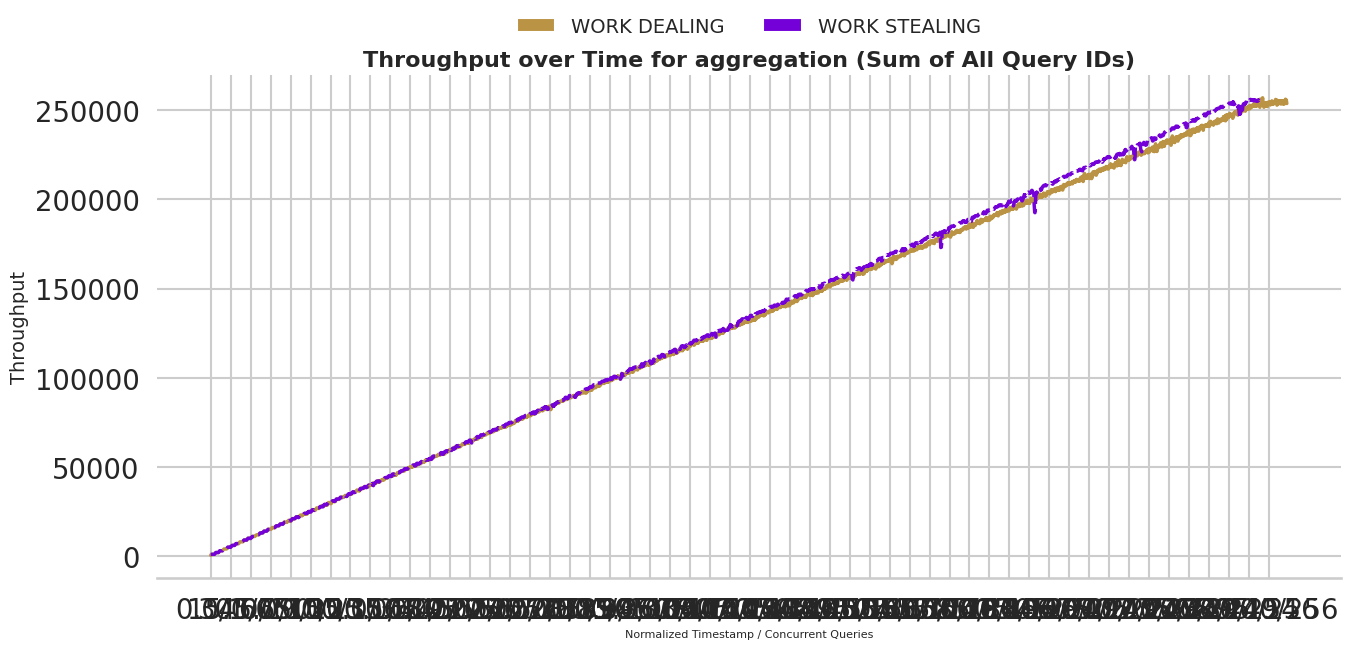

/tmp/ipykernel_60206/2794424879.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['throughput'] = df.groupby('resourceAssignment')['throughput'].transform(


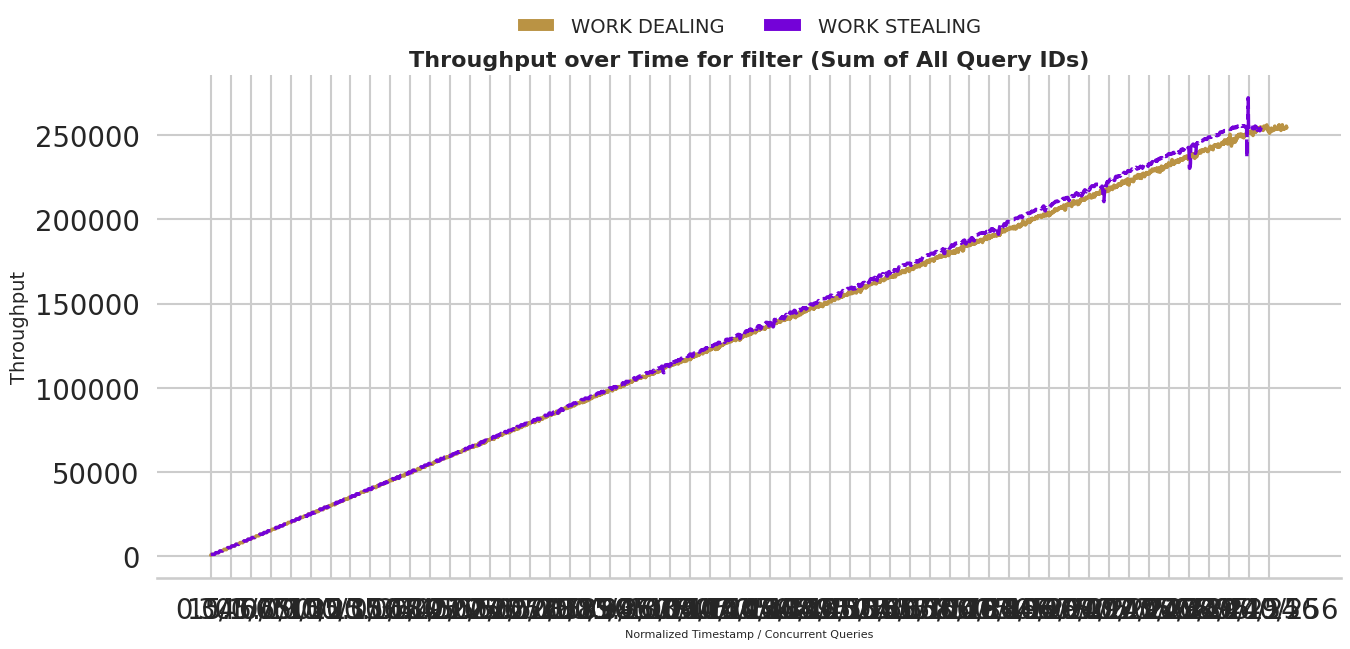

In [2]:
# Only keep timestamps smaller than n
#n = 100
#df = df[df['normalized_timestamp'] <= n]

# Aggregate data for the first plot: Sum of throughput for each query and resource assignment
df_sum = df.groupby(['query', 'normalized_timestamp', 'resourceAssignment']).sum(numeric_only=True).reset_index()

# Calculate the sum of concurrent query IDs for each timestamp
concurrent_queries = df.groupby('normalized_timestamp')['query_id'].nunique().reset_index()
concurrent_queries.rename(columns={'query_id': 'concurrent_query_count'}, inplace=True)

# Plot 1: Sum of all query_ids (hue: resource assignment) but separate plots per query
queries = df['query'].unique()

for query in queries:
    plt.figure(figsize=(14, 7))
    query_df = df_sum[df_sum['query'] == query]

    # Get the first timestamp for each query_id in the current query
    first_timestamps = df[df['query'] == query].groupby('query_id')['normalized_timestamp'].min().tolist()

    # Smooth the throughput data
    smoothed_df = smooth_throughput(query_df)

    # Plot the smoothed data with enhanced styling
    ax = sns.lineplot(data=smoothed_df, x='normalized_timestamp', y='throughput', palette=custom_palette, hue_order=hue_order, hue='resourceAssignment', style='resourceAssignment', linewidth=2.5)

    ## Add vertical lines at the first occurrence of each query_id
    #for timestamp in first_timestamps:
    #    plt.axvline(x=timestamp, color='gray', linestyle='--', alpha=0.7)

    # Customize x-axis ticks to show every 5th timestamp and concurrent query count
    unique_timestamps = sorted(smoothed_df['normalized_timestamp'].unique())
    step = 75
    plt.xticks(ticks=unique_timestamps[::step],
               labels=[f"{ts}/{concurrent_queries[concurrent_queries['normalized_timestamp'] == ts]['concurrent_query_count'].values[0]}"
                       for ts in unique_timestamps[::step]],
               rotation=0, ha='center')

    plt.title(f'Throughput over Time for {query} (Sum of All Query IDs)', fontsize=16, fontweight='bold')
    plt.xlabel('Normalized Timestamp / Concurrent Queries', fontsize=8)
    plt.ylabel('Throughput', fontsize=14)
    #plt.legend(title='Resource Assignment', title_fontsize=12, fontsize=12)
    plt.legend(title='', handles=legend_handles, fontsize=14, title_fontsize=14, labels=labels,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.15),
        ncol=2,
        frameon=False)        
    sns.despine(left=True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{query}_work_dealing_fix_equal_ingestion_rate.pdf'))
    plt.show()

/tmp/ipykernel_60206/2794424879.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['throughput'] = df.groupby('resourceAssignment')['throughput'].transform(


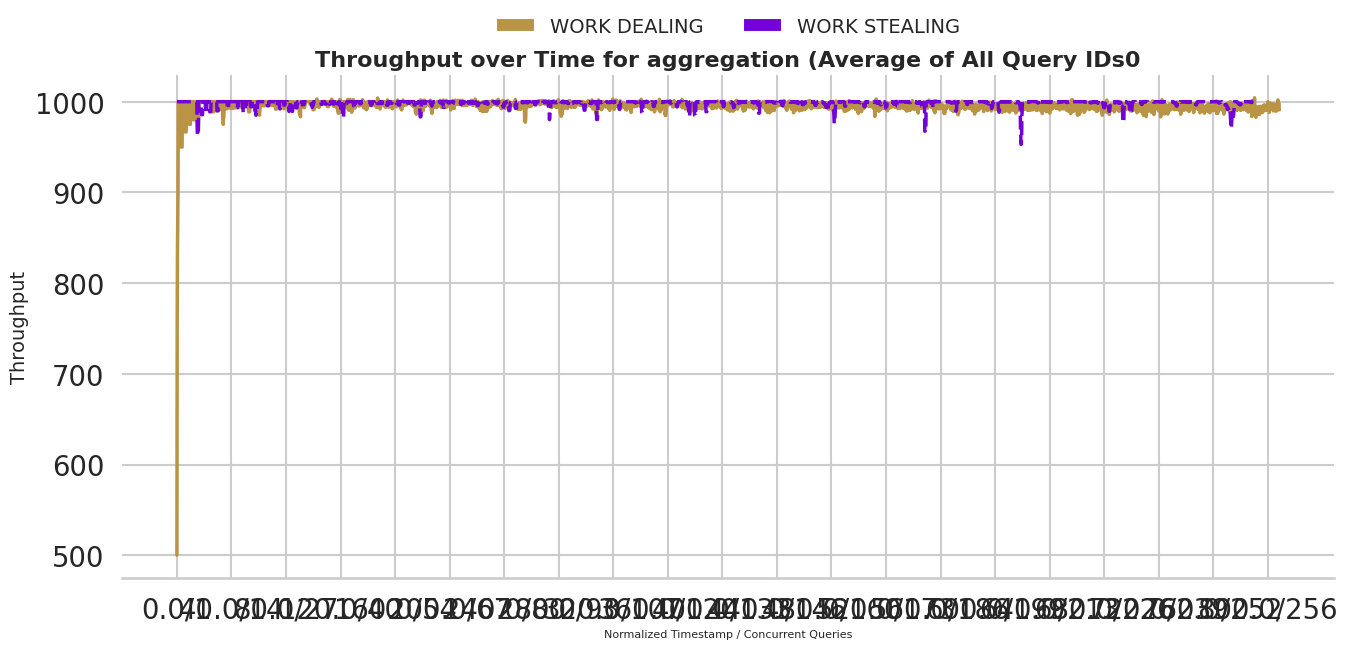

/tmp/ipykernel_60206/2794424879.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['throughput'] = df.groupby('resourceAssignment')['throughput'].transform(


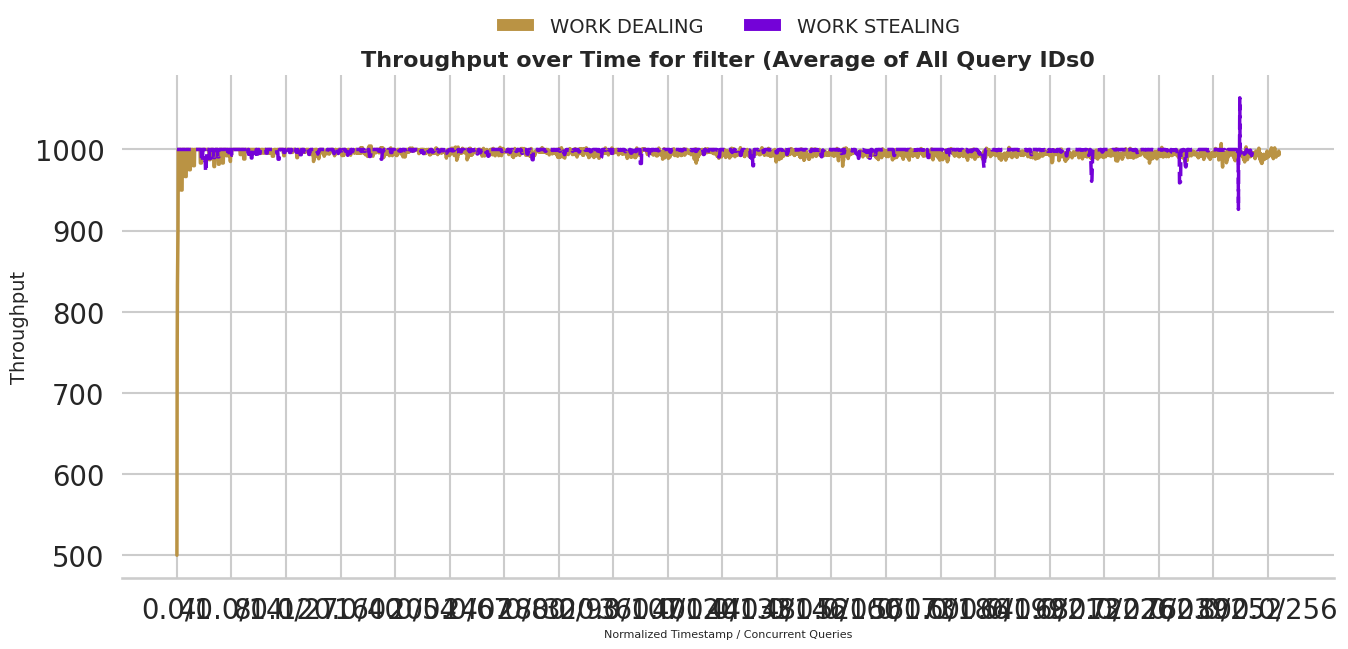

In [3]:
# Only keep timestamps smaller than n
#n = 600
#df = df[df['normalized_timestamp'] <= n]

# Aggregate data for the first plot: Sum of throughput for each query and resource assignment
df_sum = df.groupby(['query', 'normalized_timestamp', 'resourceAssignment']).mean(numeric_only=True).reset_index()

# Calculate the sum of concurrent query IDs for each timestamp
concurrent_queries = df.groupby('normalized_timestamp')['query_id'].nunique().reset_index()
concurrent_queries.rename(columns={'query_id': 'concurrent_query_count'}, inplace=True)

# Plot 1: Sum of all query_ids (hue: resource assignment) but separate plots per query
queries = df['query'].unique()

for query in queries:
    plt.figure(figsize=(14, 7))
    query_df = df_sum[df_sum['query'] == query]

    # Get the first timestamp for each query_id in the current query
    first_timestamps = df[df['query'] == query].groupby('query_id')['normalized_timestamp'].min().tolist()

    # Smooth the throughput data
    smoothed_df = smooth_throughput(query_df)

    # Plot the smoothed data with enhanced styling
    ax = sns.lineplot(data=smoothed_df, x='normalized_timestamp', y='throughput', hue='resourceAssignment', style='resourceAssignment', palette=custom_palette, hue_order=hue_order, linewidth=2.5)

    ## Add vertical lines at the first occurrence of each query_id
    #for timestamp in first_timestamps:
    #    plt.axvline(x=timestamp, color='gray', linestyle='--', alpha=0.7)

    # Customize x-axis ticks to show every 5th timestamp and concurrent query count
    unique_timestamps = sorted(smoothed_df['normalized_timestamp'].unique())
    step = 200
    plt.xticks(ticks=unique_timestamps[::step],
               labels=[f"{ts}/{concurrent_queries[concurrent_queries['normalized_timestamp'] == ts]['concurrent_query_count'].values[0]}"
                       for ts in unique_timestamps[::step]],
               rotation=0, ha='center')

    plt.title(f'Throughput over Time for {query} (Average of All Query IDs0', fontsize=16, fontweight='bold')
    plt.xlabel('Normalized Timestamp / Concurrent Queries', fontsize=8)
    plt.ylabel('Throughput', fontsize=14)
    plt.legend(title='', handles=legend_handles, fontsize=14, title_fontsize=14, labels=labels,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.15),
        ncol=2,
        frameon=False) 
    sns.despine(left=True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{query}_work_dealing_fix_equal_ingestion_rate_throughput.pdf'))
    plt.show()

In [4]:
%%script echo skipping
# Plot 2: Each query separately (hue: query_id) but separate plots per resource assignment and per query
resource_assignments = df['resourceAssignment'].unique()

for resource in resource_assignments:
    for query in queries:
        plt.figure(figsize=(14, 7))
        resource_query_df = df[(df['resourceAssignment'] == resource) & (df['query'] == query)]
        smoothed_df = smooth_throughput(resource_query_df)
        ax = sns.lineplot(data=smoothed_df, x='normalized_timestamp', y='throughput', hue='query_id', style='query_id', palette='magma', linewidth=2.5)

        ## Customize x-axis ticks to show every 5th timestamp and concurrent query count
        #unique_timestamps = sorted(smoothed_df['normalized_timestamp'].unique())
        #step = 200
        #plt.xticks(ticks=unique_timestamps[::step],
        #           labels=[f"{ts}\n{concurrent_queries[concurrent_queries['normalized_timestamp'] == ts]['concurrent_query_count'].values[0]}"
        #                   for ts in unique_timestamps[::step]],
        #           rotation=45, ha='right')

        plt.title(f'Throughput over Time for {resource} - {query}', fontsize=16, fontweight='bold')
        plt.xlabel('Normalized Timestamp / Concurrent Queries', fontsize=14)
        plt.ylabel('Throughput', fontsize=14)
        plt.legend(title='', handles=legend_handles, fontsize=14, title_fontsize=14, labels=labels,
            loc='upper center',
            bbox_to_anchor=(0.5, 1.15),
            ncol=2,
            frameon=False) 
        sns.despine(left=True)
        plt.tight_layout()
        plt.show()

skipping


In [5]:
# Set the style for the plots
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.2)

# Function to smooth only the latency data using rolling mean
def smooth_latency(df, window_size):
    df['latency_in_ms'] = df.groupby('resourceAssignment')['latency_in_ms'].transform(
        lambda x: x.rolling(window=window_size, min_periods=1).mean()
    )
    df['latency_in_us'] = df.groupby('resourceAssignment')['latency_in_us'].transform(
        lambda x: x.rolling(window=window_size, min_periods=1).mean()
    )
    return df

# Function to smooth only the latency data using Exponential Moving Average
def smooth_latency_ema(df, span):
    df['latency_in_ms'] = df.groupby('resourceAssignment')['latency_in_ms'].transform(
        lambda x: x.ewm(span=span, adjust=False).mean()
    )
    df['latency_in_us'] = df.groupby('resourceAssignment')['latency_in_us'].transform(
        lambda x: x.ewm(span=span, adjust=False).mean()
    )
    return df
    
df = pd.read_csv("latency_results_nebulastream_concat.csv")
df['normalized_start_timestamp'] = df['normalized_start_timestamp'] / 1000
df['normalized_end_timestamp'] = df['normalized_end_timestamp'] / 1000
df['latency_in_ms'] = df['latency'] * 1000
df['latency_in_us'] = df['latency'] * 1000 * 1000
df['query_resourceAssignment'] = df['query'].astype(str) + "_" + df['resourceAssignment'].astype(str)
df

,query_id,number_of_tasks,normalized_start_timestamp,normalized_end_timestamp,latency,bufferSizeInBytes,buffersInGlobalBufferManager,executionMode,joinStrategy,numberOfEntriesSliceCaches,numberOfWorkerThreads,pageSize,query,resourceAssignment,sliceCacheType,latency_in_ms,latency_in_us,query_resourceAssignment
0,1,1,0.000,0.001,0.000002,8192,4000000,COMPILER,HASH_JOIN,10,24,8192,aggregation,WORK_STEALING,SECOND_CHANCE,0.001731,1.731,aggregation_WORK_STEALING
1,1,1,0.101,0.101,0.000002,8192,4000000,COMPILER,HASH_JOIN,10,24,8192,aggregation,WORK_STEALING,SECOND_CHANCE,0.001774,1.774,aggregation_WORK_STEALING
2,1,1,0.201,0.201,0.000002,8192,4000000,COMPILER,HASH_JOIN,10,24,8192,aggregation,WORK_STEALING,SECOND_CHANCE,0.001614,1.614,aggregation_WORK_STEALING
3,1,1,0.301,0.301,0.000002,8192,4000000,COMPILER,HASH_JOIN,10,24,8192,aggregation,WORK_STEALING,SECOND_CHANCE,0.001731,1.731,aggregation_WORK_STEALING
4,1,1,0.401,0.401,0.000002,8192,4000000,COMPILER,HASH_JOIN,10,24,8192,aggregation,WORK_STEALING,SECOND_CHANCE,0.001925,1.925,aggregation_WORK_STEALING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4189692,80,1,808.763,808.763,0.000001,8192,4000000,COMPILER,HASH_JOIN,10,24,8192,filter,WORK_DEALING_NEW_QUEUE_AND_THREAD,SECOND_CHANCE,0.001444,1.444,filter_WORK_DEALING_NEW_QUEUE_AND_THREAD
4189693,199,1,808.763,808.763,0.000001,8192,4000000,COMPILER,HASH_JOIN,10,24,8192,filter,WORK_DEALING_NEW_QUEUE_AND_THREAD,SECOND_CHANCE,0.001363,1.363,filter_WORK_DEALING_NEW_QUEUE_AND_THREAD
4189694,21,1,808.763,808.763,0.000001,8192,4000000,COMPILER,HASH_JOIN,10,24,8192,filter,WORK_DEALING_NEW_QUEUE_AND_THREAD,SECOND_CHANCE,0.001121,1.121,filter_WORK_DEALING_NEW_QUEUE_AND_THREAD
4189695,54,1,808.763,808.763,0.000001,8192,4000000,COMPILER,HASH_JOIN,10,24,8192,filter,WORK_DEALING_NEW_QUEUE_AND_THREAD,SECOND_CHANCE,0.001132,1.132,filter_WORK_DEALING_NEW_QUEUE_AND_THREAD


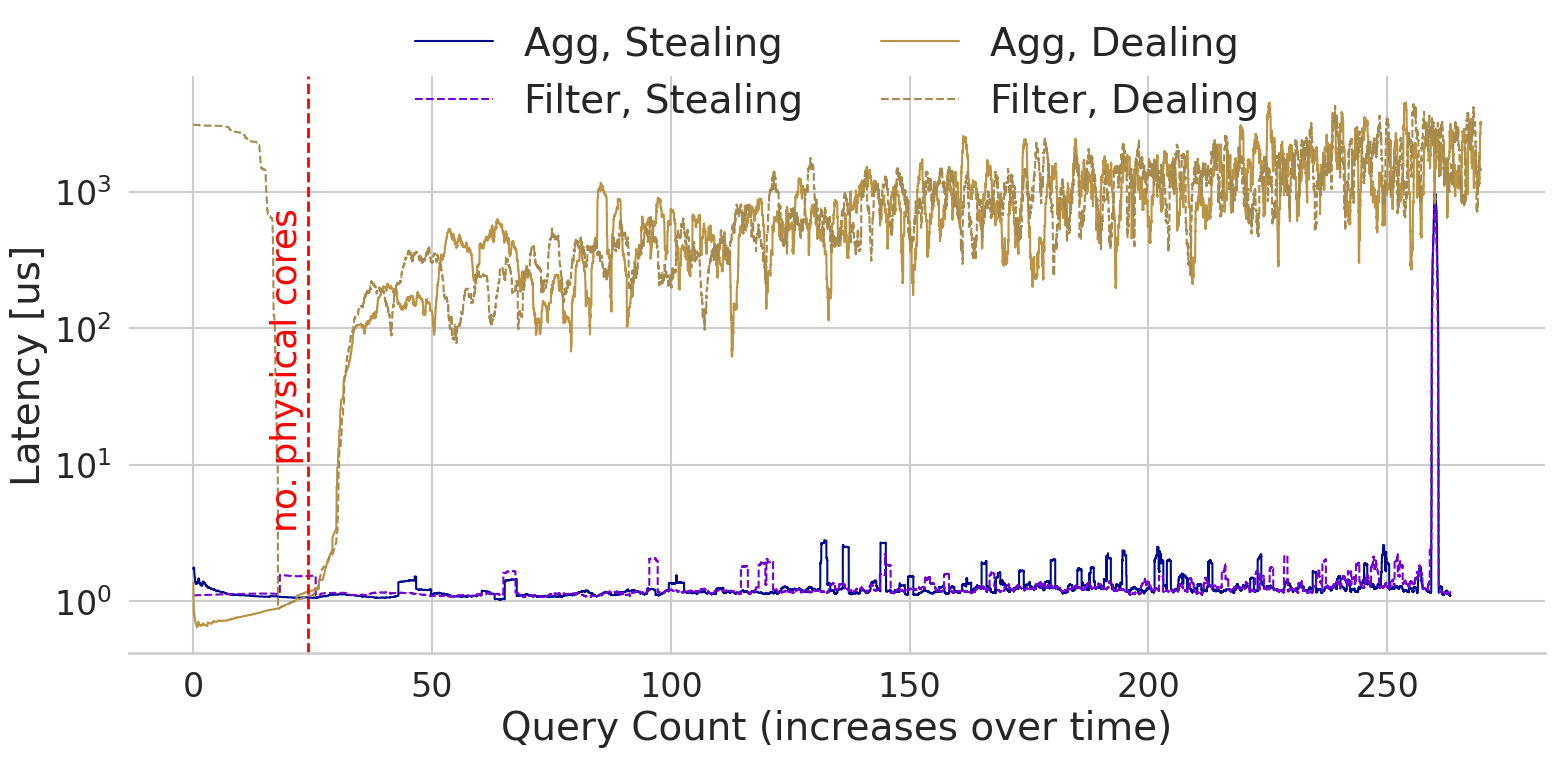

In [6]:
# Calculate concurrent queries
smoothed_df = smooth_latency(df, 5000)
smoothed_df['concurrent_queries'] = smoothed_df['normalized_start_timestamp'] / 3
smoothed_df_downsampled = smoothed_df.iloc[::5000, :]


custom_cmap = LinearSegmentedColormap.from_list("custom_shades", colors, N=100)

# Example usage in a plot
plt.figure(figsize=(16, 8))
plt.subplots_adjust(top=0.85, bottom=0.15)

# Get unique queries and resource assignments
queries = smoothed_df['query'].unique()
resources = smoothed_df['resourceAssignment'].unique()

query_labels = ["Agg", "Filter"]
resource_labels = ["Stealing", "Dealing"]

color1 = "#ba9344"  # gold/brown
color2 = "#7402d8"  # purple

# Create a custom colormap with shades of both colors
colors = [
    [
        "#000a90",  # darker purple
        color2,    # end with purple
    ],
    [
        color1,  # start with gold/brown
        "#a68a4d",  # darker gold
    ]
]

# Plot each query with a different shade
for j, resource in enumerate(resources):
    for i, query in enumerate(queries):
        subset = smoothed_df[(smoothed_df['resourceAssignment'] == resource) & (smoothed_df['query'] == query)]
        if not subset.empty:
            plt.plot(
                subset['concurrent_queries'],
                subset['latency_in_us'],
                color=colors[j][i],  # Use the custom colormap 
                linestyle='solid' if query == queries[0] else '--',
                label=f'{query_labels[i]}, {resource_labels[j]}',
                linewidth=1.5
            )

# Add vertical line and labels
plt.axvline(x=24, color='red', linestyle='--', linewidth=2)
plt.text(16, 50, 'no. physical cores', color='red', rotation=90, verticalalignment='center', fontsize=26)
plt.xlabel('Query Count (increases over time)', fontsize=28)
plt.xticks(rotation=0, fontsize=24)
plt.yticks(rotation=0, fontsize=24)
plt.ylabel('Latency [us]', fontsize=28)
plt.yscale('log')
plt.legend(fontsize=28, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, frameon=False)
sns.despine(left=True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'all_queries_work_dealing_fix_equal_ingestion_rate_latency.pdf'))
plt.show()

/tmp/ipykernel_60206/2818428257.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['latency_in_ms'] = df.groupby('resourceAssignment')['latency_in_ms'].transform(
/tmp/ipykernel_60206/2818428257.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['latency_in_us'] = df.groupby('resourceAssignment')['latency_in_us'].transform(
/tmp/ipykernel_60206/3657785564.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

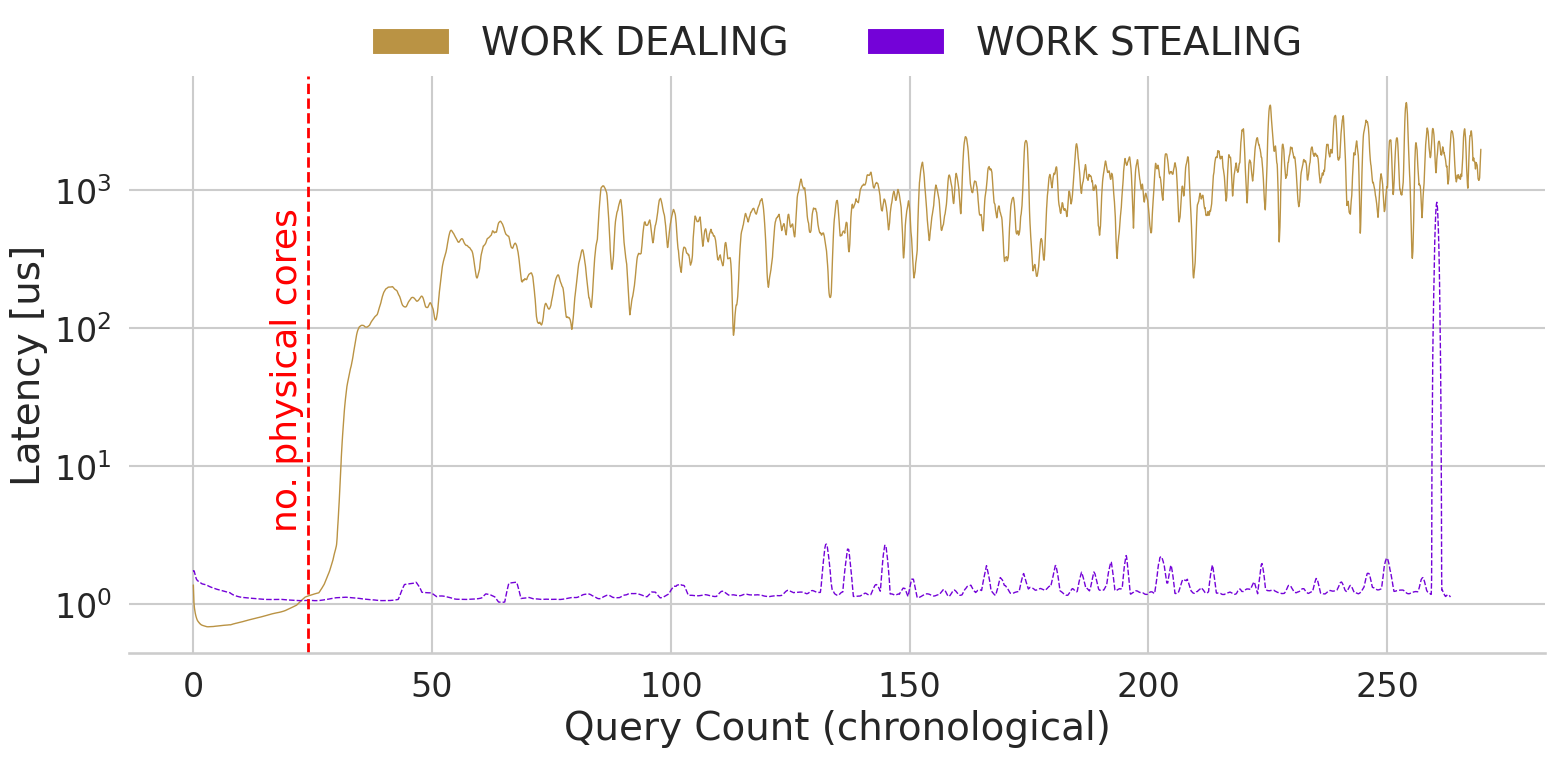

/tmp/ipykernel_60206/2818428257.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['latency_in_ms'] = df.groupby('resourceAssignment')['latency_in_ms'].transform(
/tmp/ipykernel_60206/2818428257.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['latency_in_us'] = df.groupby('resourceAssignment')['latency_in_us'].transform(
/tmp/ipykernel_60206/3657785564.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

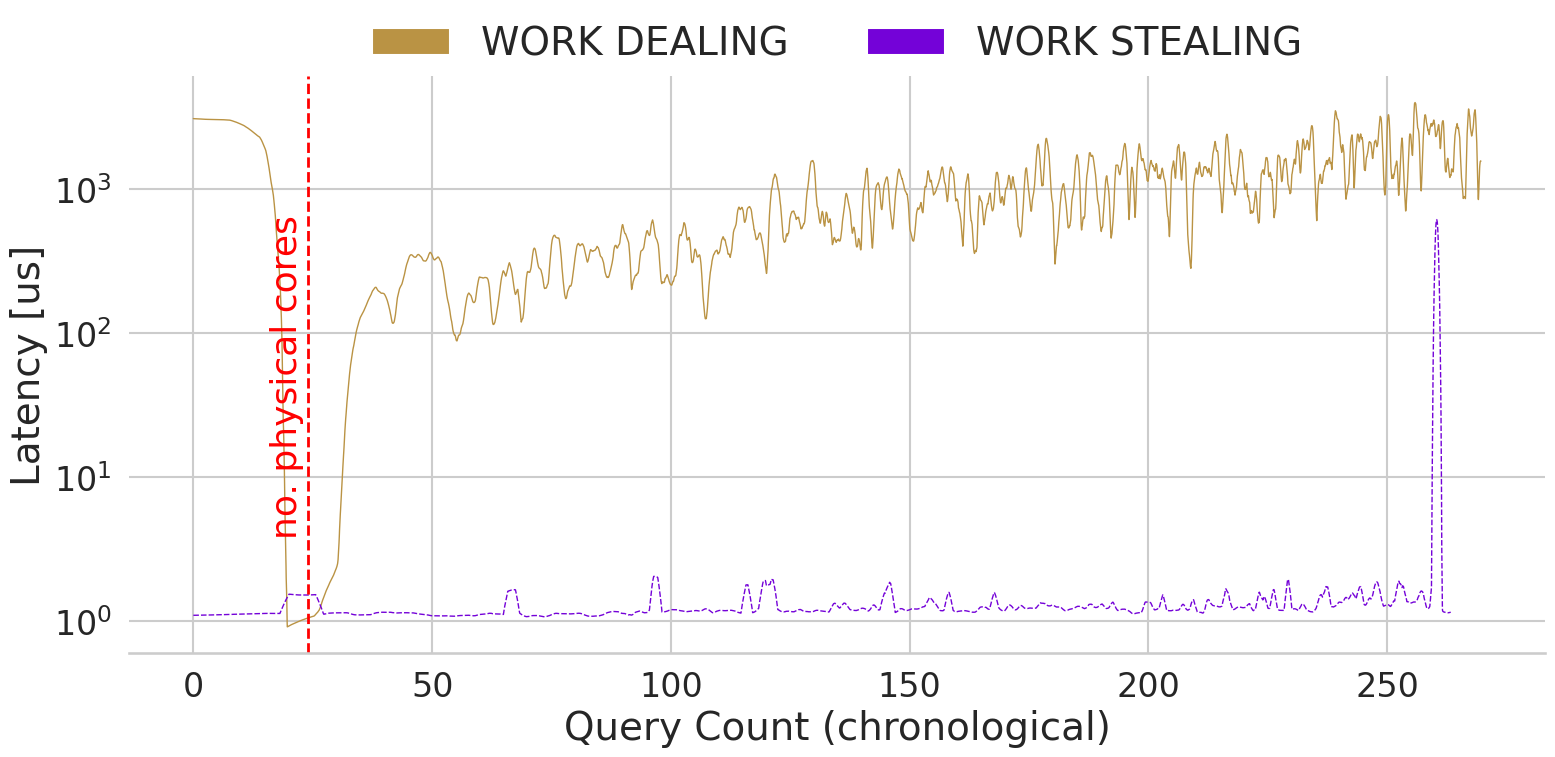

In [7]:
# Only keep timestamps smaller than n
#n = 100
#df = df[df['normalized_timestamp'] <= n]

# Aggregate data for the first plot: Sum of throughput for each query and resource assignment
df_sum = df.groupby(['query', 'normalized_start_timestamp', 'resourceAssignment']).mean(numeric_only=True).reset_index()

# Calculate the sum of concurrent query IDs for each timestamp
concurrent_queries = df.groupby('normalized_start_timestamp')['query_id'].nunique().reset_index()
concurrent_queries.rename(columns={'query_id': 'concurrent_query_count'}, inplace=True)

# Plot 1: Sum of all query_ids (hue: resource assignment) but separate plots per query
queries = df['query'].unique()

for query in queries:
    plt.figure(figsize=(16, 8))
    plt.subplots_adjust(top=0.85, bottom=0.15)  # Adjust top and bottom margins
    query_df = df_sum[df_sum['query'] == query]

    # Get the first timestamp for each query_id in the current query
    first_timestamps = df[df['query'] == query].groupby('query_id')['normalized_start_timestamp'].min().tolist()

    # Smooth the throughput data
    smoothed_df = smooth_latency(query_df, 1000)

    # Divide the values by 3, as we start a new query every 3 seconds
    smoothed_df['concurrent_queries'] = smoothed_df['normalized_start_timestamp'] / 3

    # Plot the smoothed data with enhanced styling
    ax = sns.lineplot(data=smoothed_df, x='concurrent_queries', y='latency_in_us', hue='resourceAssignment', style='resourceAssignment', palette=custom_palette, hue_order=hue_order, linewidth=1)
    # Draw a vertical line at x = 24
    plt.axvline(x=24, color='red', linestyle='--', linewidth=2)
    
    # Add text to the vertical line
    plt.text(16, 50, 'no. physical cores', color='red', rotation=90, verticalalignment='center', fontsize=26)

    #plt.title(f'Averge Latency over Time for {str(query).capitalize()}', fontsize=16, fontweight='bold')
    plt.xlabel('Query Count (chronological)', fontsize=28)
    plt.xticks(rotation=0, fontsize=24)
    plt.yticks(rotation=0, fontsize=24)
    plt.ylabel('Latency [us]', fontsize=28)
    plt.legend(title='', handles=legend_handles, fontsize=28, title_fontsize=18, labels=labels,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.15),
        ncol=2,
        frameon=False) 
    sns.despine(left=True)
    plt.yscale('log')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{query}_work_dealing_fix_equal_ingestion_rate_latency.pdf'))
    plt.show()